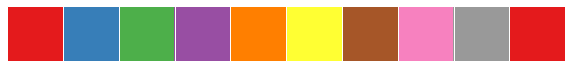

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_palette('Set1', 10)
sns.set_context('notebook', font_scale=1.2)
sns.palplot(sns.color_palette())

## Read the Dataset

### File Info.
- 문서 앱내 사용시 발생하는 클라이언 로그 데이터 (after parsed)
- 서버로그와 달리, 유저의 행동이 발생할 경우 로그 수집 (유저 행동 패턴 파악에 용이)
    - 클라이언트(앱) 로그
    - 서버 로그

In [2]:
df = pd.read_csv("/Users/woowahan/Documents/Python/DS_Ext_School/tutorial_02/df_funnel.csv", index_col=0)

In [3]:
df.head(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016.7.6,Main


In [4]:
df.tail(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLSX,2ed068d5e6a72e80e4a997c01c59f782,OTHERAPP,2016.7.7,Main
301857,OPEN,NoView,DOCX,41b8c1df291edd2aec30fc610e5b676e,OTHERAPP,2016.7.5,Main
301858,RESET,View,DOCX,41b8c1df291edd2aec30fc610e5b676e,OTHERAPP,2016.7.5,Main
301859,OPEN,NoView,PPT,9b5ee236571c2fcbe25132b6ba71d764,OTHERAPP,2016.7.14,Main
301860,CLOSE,NoView,PPT,9b5ee236571c2fcbe25132b6ba71d764,OTHERAPP,2016.7.14,Main


In [5]:
# key info => data entires, missing values, type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
actiontype          301861 non-null object
ismydoc             301861 non-null object
ext                 301861 non-null object
sessionid           301861 non-null object
documentposition    301861 non-null object
datetime            301861 non-null object
screen              301861 non-null object
dtypes: object(7)
memory usage: 18.4+ MB


### Columns Info.
- actiontype: 문서 이용시 행동(OPEN, CLOSE, SAVE,,)
- ismydoc: 내문서 해당 여부(중요x)
- ext: 문서 확장자
- sessionid: 유저 식별자
- documentposition: 문서 이용시 위치 정보(CLOUD, OTHERAPP)
- datetime: Timestamp
- screen: 앱내 화면 이름

## Preprocessing
- 데이터 타입 변환
- 데이터 값 변경
- 결측치 처리
- 신규 session id 부여
- 대소문자 처리

In [6]:
df.groupby("datetime").size()

datetime
2016.7.1     11836
2016.7.10     6750
2016.7.11    10075
2016.7.12    12340
2016.7.13    12159
2016.7.14    11721
2016.7.15    11057
2016.7.16     8513
2016.7.17     6906
2016.7.18     9987
2016.7.19    11872
2016.7.2      8884
2016.7.20    11912
2016.7.21    11599
2016.7.22    11250
2016.7.23     8390
2016.7.24     6813
2016.7.25    10081
2016.7.26    12034
2016.7.27    11593
2016.7.28    11216
2016.7.29    10721
2016.7.3      6334
2016.7.30     8087
2016.7.4      9260
2016.7.5     10988
2016.7.6     10525
2016.7.7     10153
2016.7.8     10522
2016.7.9      8283
dtype: int64

#### 날짜를 pandas datetime 형태로 변환 
[Reference](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html)
```python
## 날짜가 String인 경우 
df['datetime'] = pd.to_datetime(df['datetime'])
pd.Series(pd.to_datetime(['2005/11/23', '2010.12.31', '2011.1.1']))

## 날짜가 timestamp인 경우
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s').dt.date
pd.Series(pd.to_datetime([1349720105, 1349806505, 1349892905, 1349979305, 1350065705], unit='s'))#.dt.date

## 컬럼 타입을 바꾸는 경우
df1['datetime'] = df1['datetime'].astype('datetime64[ns]')
```

In [7]:
# string to datetime
df['datetime'] = pd.to_datetime(df['datetime'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
actiontype          301861 non-null object
ismydoc             301861 non-null object
ext                 301861 non-null object
sessionid           301861 non-null object
documentposition    301861 non-null object
datetime            301861 non-null datetime64[ns]
screen              301861 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 18.4+ MB


In [9]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main


In [10]:
df.groupby("datetime").size()

datetime
2016-07-01    11836
2016-07-02     8884
2016-07-03     6334
2016-07-04     9260
2016-07-05    10988
2016-07-06    10525
2016-07-07    10153
2016-07-08    10522
2016-07-09     8283
2016-07-10     6750
2016-07-11    10075
2016-07-12    12340
2016-07-13    12159
2016-07-14    11721
2016-07-15    11057
2016-07-16     8513
2016-07-17     6906
2016-07-18     9987
2016-07-19    11872
2016-07-20    11912
2016-07-21    11599
2016-07-22    11250
2016-07-23     8390
2016-07-24     6813
2016-07-25    10081
2016-07-26    12034
2016-07-27    11593
2016-07-28    11216
2016-07-29    10721
2016-07-30     8087
dtype: int64

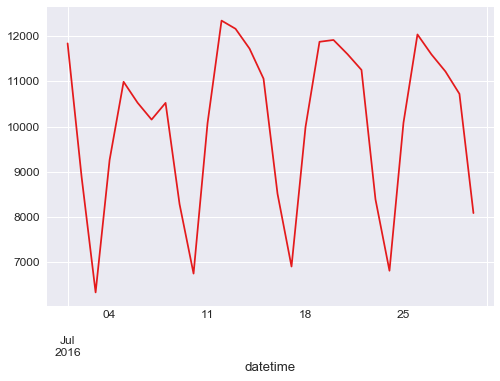

In [11]:
df.groupby("datetime").size().plot();

### Missing value 확인

In [12]:
df.isnull().sum()

actiontype          0
ismydoc             0
ext                 0
sessionid           0
documentposition    0
datetime            0
screen              0
dtype: int64

#### 결측치 처리

- 경우에 따라 결측치 처리 방법이 달라진다.
- 샘플수가 많다면 missing values 를 포함하는 행을 모두 삭제하는 것이 가능하다

```python
# 결측치가 하나라도 있으면 버리는 코드 예제
df.dropna()

# 모든 값이 Null일 경우만 버리는 코드 예제
df.dropna(how='all')

# 결측치가 하나 이상 있는 Case만 선택하는 코드 예제
df[df.isnull().any(axis=1)]
```

- 만약 샘플수가 충분하지 않을 경우, Pandas의 fillna() 명령어로 Null 값을 채우는 것이 가능하다. 
- 연속형인 경우 Mean이나 Median을 이용하고 명목형인 경우 Mode(최빈치)나 예측 모형을 통해 Null 값을 대체할 수 있다.

```python
# Null 값을 median으로 대체하는 코드 예제
df.fillna(df.mean()) 

```

In [13]:
df_by_screen = df.groupby(["datetime", "screen"])['sessionid'].nunique().unstack()

df_by_screen[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,NaN,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,NaN,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,NaN,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


In [14]:
df_by_screen.isnull().sum()

screen
InProduct_Mob    0
InProduct_Web    0
Main             0
Per_Dir          0
Pub_Dir          0
Purchase_done    6
Purchase_page    0
dtype: int64

In [15]:
df_by_screen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2016-07-01 to 2016-07-30
Data columns (total 7 columns):
InProduct_Mob    30 non-null float64
InProduct_Web    30 non-null float64
Main             30 non-null float64
Per_Dir          30 non-null float64
Pub_Dir          30 non-null float64
Purchase_done    24 non-null float64
Purchase_page    30 non-null float64
dtypes: float64(7)
memory usage: 1.9 KB


**Considering the business, the answer for missing values is zeros. But let us try different cases.**

In [16]:
df_by_screen.fillna(0)[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,0.0,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,0.0,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,0.0,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


In [17]:
# dropna with 'how' param
df_by_screen.dropna(how='any')[:10] # how='all' or 'any'

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0
2016-07-10,62.0,122.0,1872.0,230.0,636.0,2.0,18.0
2016-07-12,138.0,157.0,3646.0,371.0,1000.0,4.0,26.0
2016-07-13,132.0,172.0,3544.0,334.0,988.0,1.0,35.0


In [18]:
df_by_screen.dropna(how='all')[:10] # how='all' or 'any'

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,NaN,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,NaN,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,NaN,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


In [19]:
# select ony rows, including NaN
df_by_screen[df_by_screen.isnull().any(axis=1)]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-03,50.0,83.0,1886.0,165.0,590.0,NaN,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,NaN,29.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,NaN,18.0
2016-07-11,125.0,139.0,2944.0,332.0,801.0,NaN,26.0
2016-07-18,133.0,162.0,2882.0,317.0,841.0,NaN,30.0
2016-07-19,124.0,137.0,3552.0,331.0,934.0,NaN,24.0


In [20]:
# fill NaN
df_by_screen.fillna(df_by_screen.median())[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,2.0,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,2.0,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,2.0,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


**What if there are nulls in categorical cols?**
- Mode
- Fill NaN with a predictive model

In [21]:
df.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [22]:
df_ms = df.copy() # it helps to test any code or functions

df_ms.ix[2, 'documentposition'] = np.nan
df_ms.ix[5, 'documentposition'] = np.nan
df_ms.ix[7, 'documentposition'] = np.nan
df_ms.ix[10, 'documentposition'] = np.nan
df_ms.ix[11, 'documentposition'] = np.nan
df_ms.ix[15, 'documentposition'] = np.nan

In [23]:
df_ms.head(20)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [24]:
# fillna with most frequent value (MODE)
freq_values = df_ms.documentposition.value_counts().index[0]

freq_values

'OTHERAPP'

In [25]:
df_ms['documentposition'] = df_ms['documentposition'].fillna(freq_values)

In [26]:
df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,OTHERAPP,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [27]:
# let's use a machine learning model to fill null
df_ms.ix[2, 'documentposition'] = np.nan
df_ms.ix[5, 'documentposition'] = np.nan
df_ms.ix[7, 'documentposition'] = np.nan
df_ms.ix[10, 'documentposition'] = np.nan
df_ms.ix[11, 'documentposition'] = np.nan
df_ms.ix[15, 'documentposition'] = np.nan

df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [28]:
# fill na using predictive model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

ind_cols = ['actiontype', 'ismydoc', 'ext', 'screen']

# train without na
df_ms1 = df_ms.dropna()

# split ind, tar
df_ms_ind = df_ms1[ind_cols]
df_ms_tar = df_ms1[['documentposition']]

In [29]:
df_ms_ind.head(10) # independent vars

,actiontype,ismydoc,ext,screen
0,OPEN,NoView,PDF,Per_Dir
1,CLOSE,NoView,PDF,Per_Dir
3,CLOSE,View,PDF,Pub_Dir
4,OPEN,NoView,PDF,Main
6,CLOSE,NoView,PDF,Main
8,OPEN,NoView,PDF,Main
9,CLOSE,NoView,PDF,Main
12,CLOSE,NoView,PDF,Main
13,RESET,View,PDF,Main
14,OPEN,View,PDF,Pub_Dir


In [30]:
df_ms_tar[:10] # target vars

,documentposition
0,LOCALSTORAGE
1,LOCALSTORAGE
3,MYPOLARISDRIVE
4,OTHERAPP
6,OTHERAPP
8,OTHERAPP
9,OTHERAPP
12,OTHERAPP
13,OTHERAPP
14,MYPOLARISDRIVE


In [31]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder

LabelEncoder()

In [32]:
df_ms_ind = df_ms_ind.apply(lambda x: encoder.fit_transform(x))

df_ms_ind.head(10)

,actiontype,ismydoc,ext,screen
0,3,0,5,3
1,0,0,5,3
3,0,1,5,4
4,3,0,5,2
6,0,0,5,2
8,3,0,5,2
9,0,0,5,2
12,0,0,5,2
13,4,1,5,2
14,3,1,5,4


In [33]:
df_ms_tar = df_ms_tar.apply(lambda y: encoder.fit_transform(y))

df_ms_tar[:10]

,documentposition
0,0
1,0
3,1
4,4
6,4
8,4
9,4
12,4
13,4
14,1


In [34]:
## the cross validation phase
# X: df_ms_ind / y: df_ms_tar

X_train, X_test, y_train, y_test = train_test_split(df_ms_ind, df_ms_tar, random_state=0)

In [35]:
print(df_ms_ind.shape)
print(df_ms_tar.shape)

(301855, 4)
(301855, 1)


In [36]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

((226391, 4), (226391, 1))
((75464, 4), (75464, 1))


[KNN Algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [38]:
accuracy_tr = knn.score(X_train, y_train)

print accuracy_tr

0.9999204915389746


In [39]:
accuracy = knn.score(X_test, y_test)

print accuracy

0.9998542351319835


In [40]:
knn_pred = knn.predict(X_test)
knn_pred[:20]

array([4, 3, 1, 1, 4, 0, 4, 4, 4, 4, 4, 4, 0, 1, 4, 4, 4, 1, 4, 1])

In [41]:
pd.Series(knn_pred).value_counts().sort_index()

0     4748
1    14003
2     1906
3     1044
4    53337
5      410
6       16
dtype: int64

In [42]:
class_cd = pd.Series(encoder.classes_)

class_cd

0      LOCALSTORAGE
1    MYPOLARISDRIVE
2       NEWDOCUMENT
3              NONE
4          OTHERAPP
5        OTHERCLOUD
6    SHAREDDOCUMENT
dtype: object

In [43]:
confusion_matrix(y_test, knn_pred)

array([[ 4747,     0,     0,     0,     1,     0,     0],
       [    1, 14000,     0,     0,     0,     0,     0],
       [    0,     0,  1903,     0,     3,     0,     0],
       [    0,     0,     0,  1044,     0,     0,     0],
       [    0,     0,     3,     0, 53333,     0,     0],
       [    0,     0,     0,     0,     0,   410,     0],
       [    0,     3,     0,     0,     0,     0,    16]])

In [44]:
df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [45]:
df_ms.isnull().sum()

actiontype          0
ismydoc             0
ext                 0
sessionid           0
documentposition    6
datetime            0
screen              0
dtype: int64

In [46]:
df_ms1 = df_ms[df_ms.isnull().any(axis=1)]

df_ms1

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
10,OPEN,View,PDF,3da5ab986c93803de1e25012d9972274,NaN,2016-07-28,Main
11,OPEN,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,NaN,2016-07-19,Main
15,CLOSE,View,PDF,450e74586e6a05f2983905205e8f8cb1,NaN,2016-07-24,Pub_Dir


In [47]:
knn.predict(df_ms1[ind_cols].apply(lambda x: encoder.fit_transform(x)))

array([2, 2, 3, 3, 3, 2])

In [48]:
class_cd

0      LOCALSTORAGE
1    MYPOLARISDRIVE
2       NEWDOCUMENT
3              NONE
4          OTHERAPP
5        OTHERCLOUD
6    SHAREDDOCUMENT
dtype: object

In [49]:
df_ms1['documentposition'] = knn.predict(df_ms1[ind_cols].apply(lambda x: encoder.fit_transform(x)))

In [50]:
df_ms1

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,2,2016-07-18,Pub_Dir
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,2,2016-07-06,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,3,2016-07-20,Main
10,OPEN,View,PDF,3da5ab986c93803de1e25012d9972274,3,2016-07-28,Main
11,OPEN,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,3,2016-07-19,Main
15,CLOSE,View,PDF,450e74586e6a05f2983905205e8f8cb1,2,2016-07-24,Pub_Dir


In [51]:
replace_cd = class_cd.to_dict()

replace_cd 

{0: 'LOCALSTORAGE',
 1: 'MYPOLARISDRIVE',
 2: 'NEWDOCUMENT',
 3: 'NONE',
 4: 'OTHERAPP',
 5: 'OTHERCLOUD',
 6: 'SHAREDDOCUMENT'}

In [52]:
df_ms1['documentposition'] = df_ms1['documentposition'].replace(replace_cd)

In [53]:
df_ms1

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NEWDOCUMENT,2016-07-18,Pub_Dir
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NEWDOCUMENT,2016-07-06,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NONE,2016-07-20,Main
10,OPEN,View,PDF,3da5ab986c93803de1e25012d9972274,NONE,2016-07-28,Main
11,OPEN,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,NONE,2016-07-19,Main
15,CLOSE,View,PDF,450e74586e6a05f2983905205e8f8cb1,NEWDOCUMENT,2016-07-24,Pub_Dir


In [54]:
df_fin = pd.concat([df_ms.dropna(how='any'), df_ms1], axis=0)

df_fin.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main


In [55]:
df_fin.tail()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NEWDOCUMENT,2016-07-06,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NONE,2016-07-20,Main
10,OPEN,View,PDF,3da5ab986c93803de1e25012d9972274,NONE,2016-07-28,Main
11,OPEN,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,NONE,2016-07-19,Main
15,CLOSE,View,PDF,450e74586e6a05f2983905205e8f8cb1,NEWDOCUMENT,2016-07-24,Pub_Dir


#### When to use a preidct model for handling missing values
- The number of samples is too small
- Create a class or functions for the above process, and apply it to the system

### 확장자명 통일

In [56]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main


In [57]:
df.ext.value_counts()

PDF      82004
DOCX     58303
XLSX     52118
HWP      26244
DOC      24586
XLS      24489
PPTX     15385
TXT       9814
PPT       5382
PPSX      2374
ODT        820
PPS        324
JPG          9
SHEET        5
WORD         2
PNG          2
Name: ext, dtype: int64

In [58]:
ext_dic = {'DOCX': 'DOC',
           'XLSX': 'XLS',
           'PPTX': 'PPT',
           'PPSX': 'PPT',
           'PPS': 'PPT',
           'ODT': 'TXT',
           'PNG': 'JPG'}

ext_dic

{'DOCX': 'DOC',
 'ODT': 'TXT',
 'PNG': 'JPG',
 'PPS': 'PPT',
 'PPSX': 'PPT',
 'PPTX': 'PPT',
 'XLSX': 'XLS'}

In [59]:
df['ext'] = df['ext'].replace(ext_dic)

In [60]:
df['ext'].value_counts()

DOC      82889
PDF      82004
XLS      76607
HWP      26244
PPT      23465
TXT      10634
JPG         11
SHEET        5
WORD         2
Name: ext, dtype: int64

### Action Type 통일

In [61]:
df.actiontype.value_counts()

OPEN            151802
CLOSE           127922
SAVE              9334
RESET             7751
SAVEAS            4960
EXPORT_SAME         68
EXPORT              19
SAVEAS_OTHER         5
Name: actiontype, dtype: int64

In [62]:
act_dic = {'SAVEAS': 'SAVE',
           'SAVEAS_OTHER': 'SAVE',
           'EXPORT_SAME': 'EXPORT'
            }

In [63]:
df['actiontype'] = df['actiontype'].replace(act_dic)

In [64]:
df['actiontype'].value_counts()

OPEN      151802
CLOSE     127922
SAVE       14299
RESET       7751
EXPORT        87
Name: actiontype, dtype: int64

### 신규  session_id 부여

In [65]:
s = [] # empty list
j = 0 # default setting

# loop
for i in range(len(df)-1):
    
    # compare each rows
    if df.ix[i, 'sessionid'] == df.ix[i+1, 'sessionid']:
        s.append(j)

    # update j values
    else:
        s.append(j)
        j += 1

In [66]:
s[:20]

[0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 7]

In [67]:
df['sessionid']  = pd.Series(['s' + str(x) for x in s]) # convert to string as add character 's'

In [68]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,s0,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,s0,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,s0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,s0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,s1,OTHERAPP,2016-07-06,Main


In [69]:
df.tail(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLS,s132151,OTHERAPP,2016-07-07,Main
301857,OPEN,NoView,DOC,s132152,OTHERAPP,2016-07-05,Main
301858,RESET,View,DOC,s132152,OTHERAPP,2016-07-05,Main
301859,OPEN,NoView,PPT,s132153,OTHERAPP,2016-07-14,Main
301860,CLOSE,NoView,PPT,NaN,OTHERAPP,2016-07-14,Main


In [70]:
# fill missing values for the last row
df['sessionid'] = df['sessionid'].fillna(method='ffill')

In [71]:
df.tail(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLS,s132151,OTHERAPP,2016-07-07,Main
301857,OPEN,NoView,DOC,s132152,OTHERAPP,2016-07-05,Main
301858,RESET,View,DOC,s132152,OTHERAPP,2016-07-05,Main
301859,OPEN,NoView,PPT,s132153,OTHERAPP,2016-07-14,Main
301860,CLOSE,NoView,PPT,s132153,OTHERAPP,2016-07-14,Main


### 대소문자 처리

In [72]:
cols = df.columns # list of columns' names

# loop
for c in cols:
    if c != 'datetime':  
        df[c] = df[c].apply(lambda x: x.lower())

In [73]:
cols

Index([u'actiontype', u'ismydoc', u'ext', u'sessionid', u'documentposition',
       u'datetime', u'screen'],
      dtype='object')

In [74]:
df.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,open,noview,pdf,s0,localstorage,2016-07-18,per_dir
1,close,noview,pdf,s0,localstorage,2016-07-18,per_dir
2,open,view,pdf,s0,mypolarisdrive,2016-07-18,pub_dir
3,close,view,pdf,s0,mypolarisdrive,2016-07-18,pub_dir
4,open,noview,pdf,s1,otherapp,2016-07-06,main
5,reset,view,pdf,s1,otherapp,2016-07-06,main
6,close,noview,pdf,s2,otherapp,2016-07-20,main
7,open,noview,pdf,s2,otherapp,2016-07-20,main
8,open,noview,pdf,s3,otherapp,2016-07-28,main
9,close,noview,pdf,s3,otherapp,2016-07-28,main


## EDA (탐색적 데이터 분석)
- 일별 TREND
- 구간별 전환율 및 이탈율
- 이용 형태별 전환율, 이탈율 패턴의 차이
- 시사점 및 개선안

### 일별 Trend

In [75]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,open,noview,pdf,s0,localstorage,2016-07-18,per_dir
1,close,noview,pdf,s0,localstorage,2016-07-18,per_dir
2,open,view,pdf,s0,mypolarisdrive,2016-07-18,pub_dir
3,close,view,pdf,s0,mypolarisdrive,2016-07-18,pub_dir
4,open,noview,pdf,s1,otherapp,2016-07-06,main


In [76]:
df.groupby("datetime").size()

datetime
2016-07-01    11836
2016-07-02     8884
2016-07-03     6334
2016-07-04     9260
2016-07-05    10988
2016-07-06    10525
2016-07-07    10153
2016-07-08    10522
2016-07-09     8283
2016-07-10     6750
2016-07-11    10075
2016-07-12    12340
2016-07-13    12159
2016-07-14    11721
2016-07-15    11057
2016-07-16     8513
2016-07-17     6906
2016-07-18     9987
2016-07-19    11872
2016-07-20    11912
2016-07-21    11599
2016-07-22    11250
2016-07-23     8390
2016-07-24     6813
2016-07-25    10081
2016-07-26    12034
2016-07-27    11593
2016-07-28    11216
2016-07-29    10721
2016-07-30     8087
dtype: int64

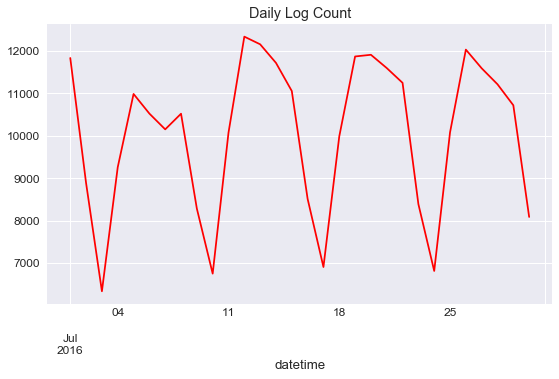

In [77]:
# daily log size
df.groupby("datetime").size().plot(c='r');

plt.title("Daily Log Count")
plt.tight_layout()

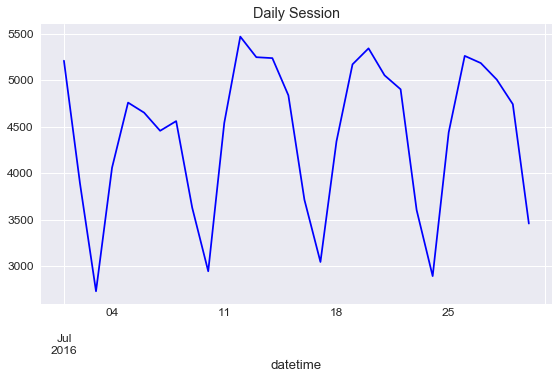

In [78]:
# daily session count => activness index
df.groupby("datetime")['sessionid'].nunique().plot(c='b');

plt.title("Daily Session")
plt.tight_layout()

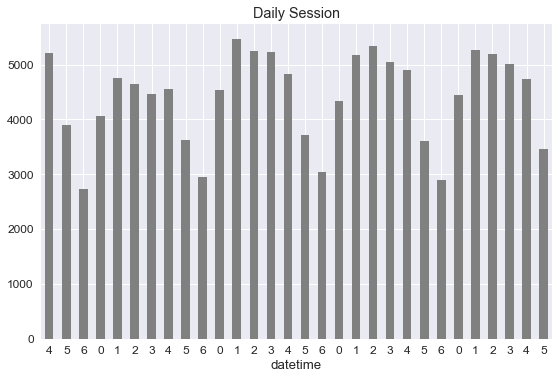

In [79]:
## daily session count (weekofday)
# 0: Monday, 6: Sunday

s = df.groupby("datetime")['sessionid'].nunique()
s.index = s.index.dayofweek

s.plot(color='grey', kind='bar', rot=0);

plt.title("Daily Session")
plt.tight_layout()

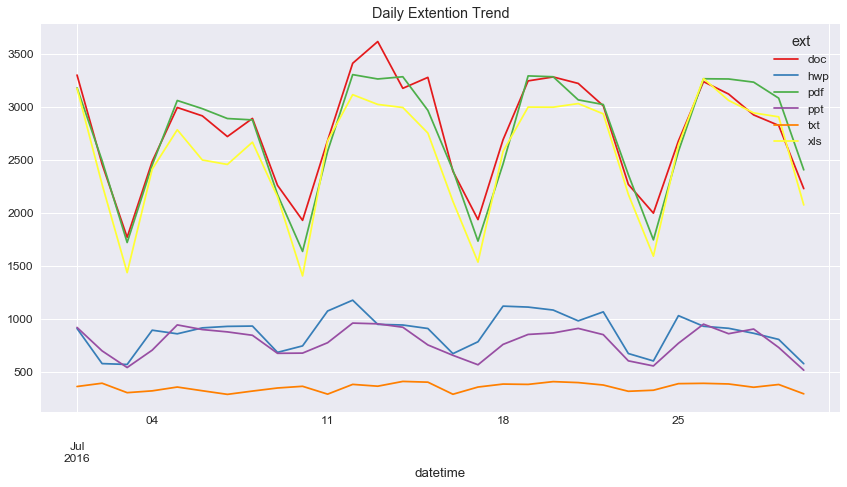

In [80]:
# daily trend by extention
df.groupby(["datetime", "ext"]).size().unstack().dropna(axis=1).plot(figsize=(12,7));

plt.title("Daily Extention Trend")
plt.tight_layout()

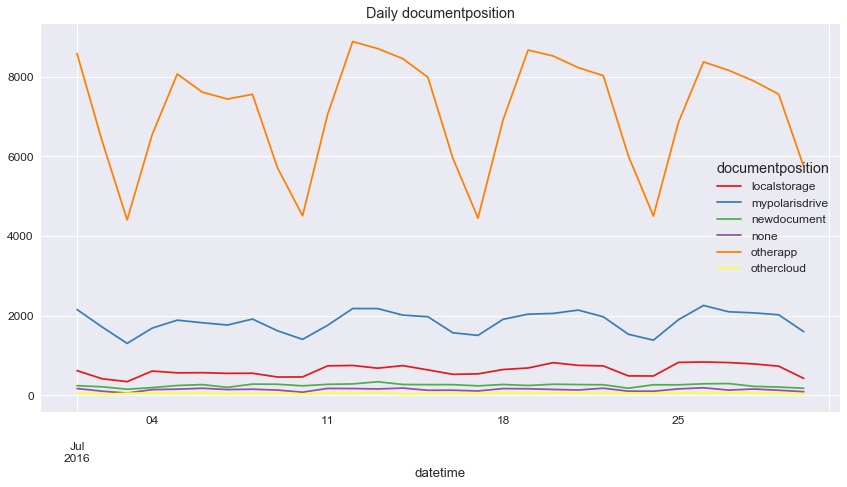

In [81]:
# daily trend by doc position
df.groupby(["datetime", "documentposition"]).size().unstack().dropna(axis=1).plot(figsize=(12,7));

plt.title("Daily documentposition")
plt.tight_layout()

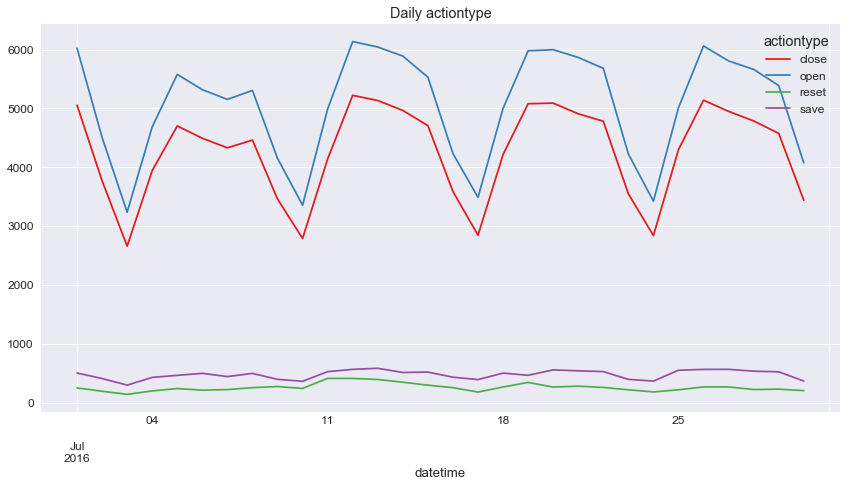

In [82]:
# daily trend by action type
df.groupby(["datetime", "actiontype"]).size().unstack().dropna(axis=1).plot(figsize=(12,7));

plt.title("Daily actiontype")
plt.tight_layout()

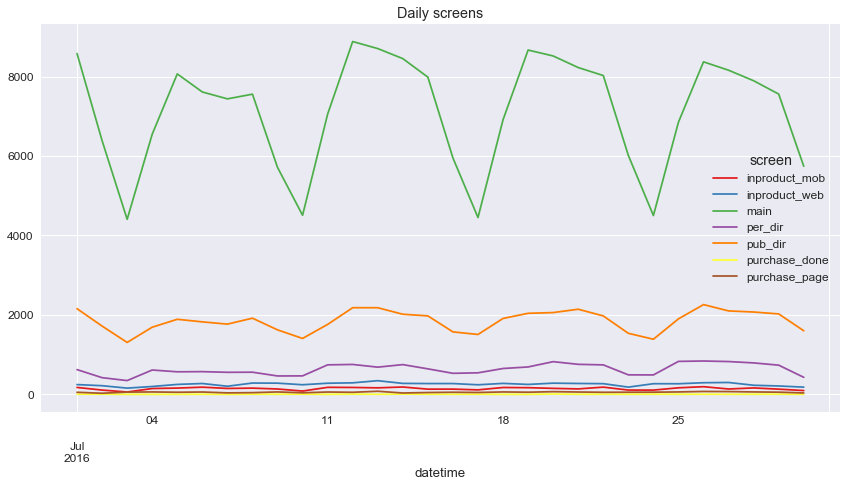

In [83]:
# daily trend by screen name
df.groupby(["datetime", "screen"]).size().unstack().fillna(0).astype(int).plot(figsize=(12,7));

plt.title("Daily screens")
plt.tight_layout()

In [84]:
# heat map
screens = df.groupby(["datetime", "screen"])['sessionid'].nunique().unstack().fillna(0).astype(int)

# cols order change
screens = screens[screens.mean().sort_values(ascending=False).index]

screens[:10]

screen,main,pub_dir,per_dir,inproduct_web,inproduct_mob,purchase_page,purchase_done
datetime,,,,,,,
2016-07-01,3911,1112,381,178,143,24,2
2016-07-02,2935,888,251,140,92,15,2
2016-07-03,2005,648,197,85,50,33,0
2016-07-04,3016,847,349,120,124,32,0
2016-07-05,3631,942,354,159,127,28,1
2016-07-06,3525,949,374,163,148,31,1
2016-07-07,3433,896,324,133,127,18,0
2016-07-08,3477,961,339,169,127,23,2
2016-07-09,2605,865,277,178,110,30,2


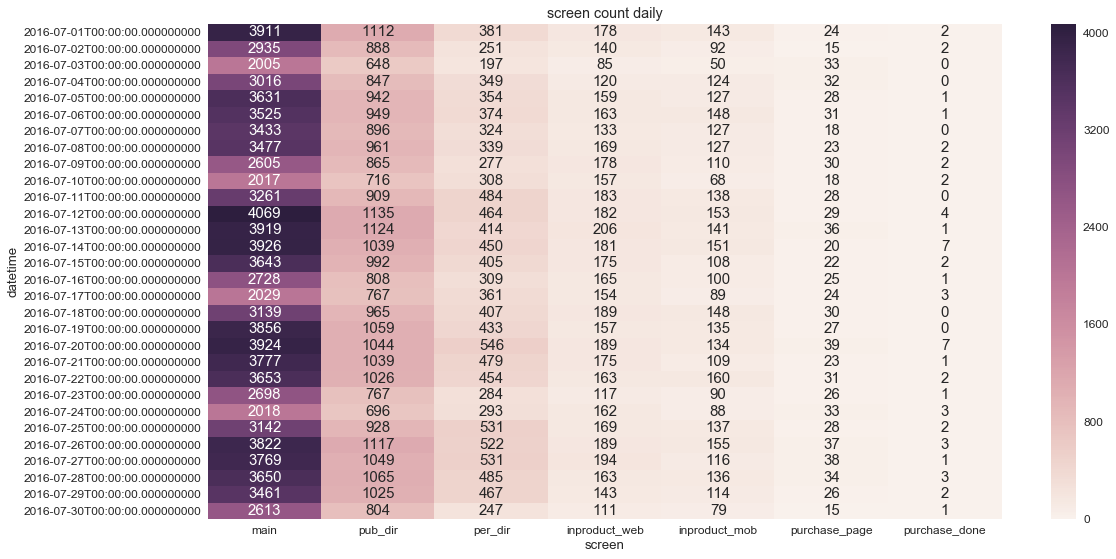

In [85]:
plt.subplots(figsize=(17,8))

sns.heatmap(screens, annot=True, fmt="d", annot_kws={"size": 15}); # we can do the same via Excel

plt.title("screen count daily")
plt.tight_layout()

### 변수별 특성
- from log to user-based data which contains the useful features

In [86]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,open,noview,pdf,s0,localstorage,2016-07-18,per_dir
1,close,noview,pdf,s0,localstorage,2016-07-18,per_dir
2,open,view,pdf,s0,mypolarisdrive,2016-07-18,pub_dir
3,close,view,pdf,s0,mypolarisdrive,2016-07-18,pub_dir
4,open,noview,pdf,s1,otherapp,2016-07-06,main


In [87]:
df_by_user = df.groupby(["sessionid", "actiontype"]).size().unstack()

df_by_user.head(10)

actiontype,close,export,open,reset,save
sessionid,,,,,
s0,2.0,NaN,2.0,NaN,NaN
s1,NaN,NaN,1.0,1.0,NaN
s10,NaN,NaN,2.0,NaN,1.0
s100,NaN,NaN,1.0,NaN,NaN
s1000,NaN,NaN,1.0,NaN,NaN
s10000,1.0,NaN,1.0,1.0,NaN
s100000,1.0,NaN,1.0,NaN,NaN
s100001,1.0,NaN,1.0,NaN,NaN
s100002,1.0,NaN,1.0,NaN,NaN


In [88]:
df_by_user.describe()

actiontype,close,export,open,reset,save
count,103424.000000,80.000000,120657.000000,7474.000000,12502.000000
mean,1.236870,1.087500,1.258128,1.037062,1.143737
std,0.594519,0.284349,0.606139,0.207814,0.440046
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,11.000000,2.000000,11.000000,5.000000,10.000000


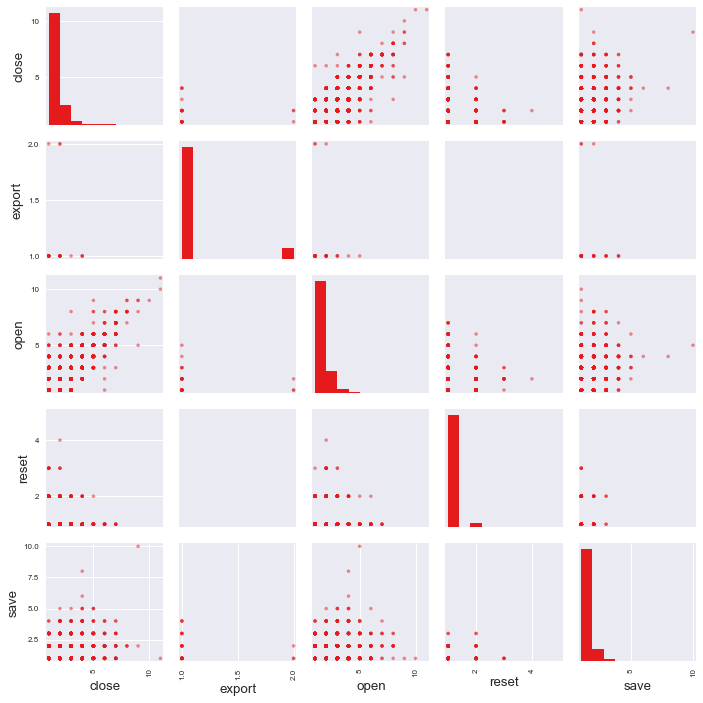

In [89]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(df_by_user, figsize=(10, 10));

plt.tight_layout()

In [90]:
df_by_user.corr()

actiontype,close,export,open,reset,save
actiontype,,,,,
close,1.000000,-0.066216,0.845005,0.050415,0.389834
export,-0.066216,1.000000,-0.124424,NaN,-0.125441
open,0.845005,-0.124424,1.000000,0.125758,0.341042
reset,0.050415,NaN,0.125758,1.000000,0.027279
save,0.389834,-0.125441,0.341042,0.027279,1.000000


### 구간별 전환율

In [91]:
conver_cnt = screens.mean().apply(lambda x: int(x)).sort_values(ascending=False)

conver_cnt

screen
main             3255
pub_dir           939
per_dir           390
inproduct_web     161
inproduct_mob     119
purchase_page      27
purchase_done       1
dtype: int64

In [92]:
try:
    for i in range(len(conver_cnt)):
        print(conver_cnt[i + 1] / (conver_cnt[i] * 1.0) * 100)

except IndexError, e:
    print(e)

28.847926267281103
41.533546325878596
41.28205128205128
73.91304347826086
22.689075630252102
3.7037037037037033
index out of bounds


In [93]:
conver_rt = [conver_cnt[i + 1] / (conver_cnt[i] * 1.0) * 100 for i in range(len(conver_cnt)) if i < 6]

conver_rt

[28.847926267281103,
 41.533546325878596,
 41.28205128205128,
 73.91304347826086,
 22.689075630252102,
 3.7037037037037033]

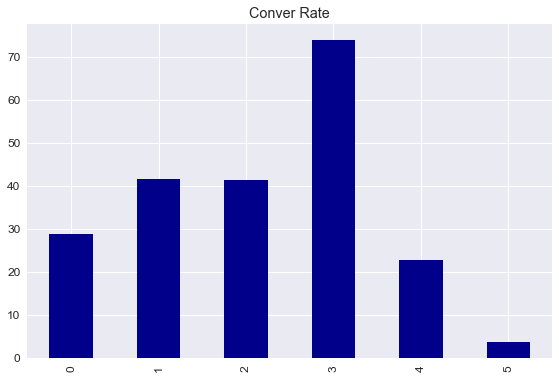

In [94]:
pd.Series(conver_rt).plot(kind='bar', color = 'darkblue')

plt.title("Conver Rate")
plt.tight_layout()

In [95]:
fun_label = [conver_cnt.index[k] + " -> " + conver_cnt.index[k + 1] for k, v in enumerate(conver_cnt.index) if k < 6]

fun_label

['main -> pub_dir',
 'pub_dir -> per_dir',
 'per_dir -> inproduct_web',
 'inproduct_web -> inproduct_mob',
 'inproduct_mob -> purchase_page',
 'purchase_page -> purchase_done']

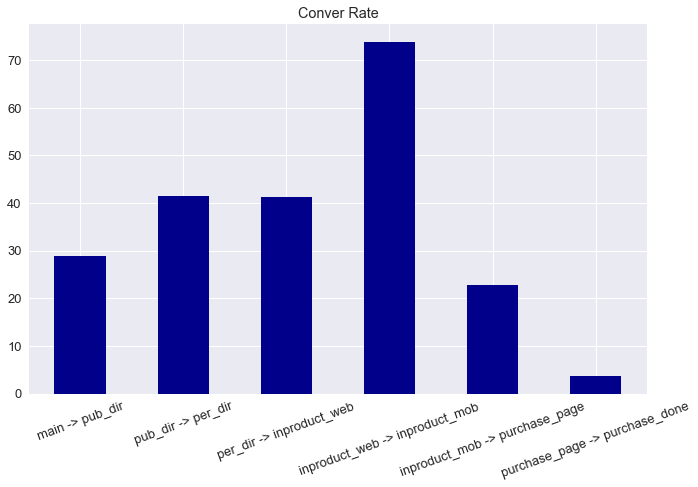

In [96]:
pd.Series(conver_rt, index=fun_label).plot(kind='bar', color = 'darkblue', rot=20, figsize=(10,7), fontsize=13)

plt.title("Conver Rate")
plt.tight_layout()

In [97]:
conv_rt_tb = pd.Series(conver_rt, index=fun_label).to_frame()

conv_rt_tb.index.name = 'Funnel'
conv_rt_tb.columns = ['conver_rt']

conv_rt_tb['churn_rt'] = 100 - conv_rt_tb['conver_rt']

conv_rt_tb

,conver_rt,churn_rt
Funnel,,
main -> pub_dir,28.847926,71.152074
pub_dir -> per_dir,41.533546,58.466454
per_dir -> inproduct_web,41.282051,58.717949
inproduct_web -> inproduct_mob,73.913043,26.086957
inproduct_mob -> purchase_page,22.689076,77.310924
purchase_page -> purchase_done,3.703704,96.296296


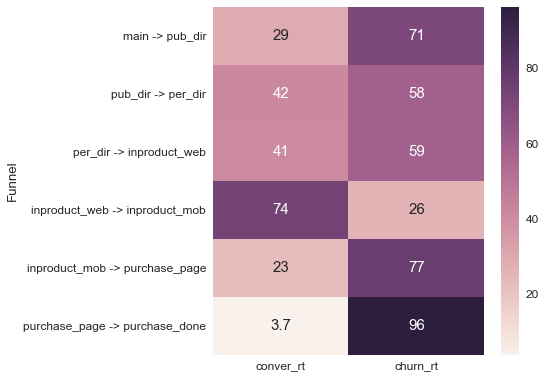

In [98]:
sns.heatmap(conv_rt_tb, annot=True, annot_kws={"size": 15});

plt.tight_layout()

### 클러스터별 전환율 차이

In [99]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,open,noview,pdf,s0,localstorage,2016-07-18,per_dir
1,close,noview,pdf,s0,localstorage,2016-07-18,per_dir
2,open,view,pdf,s0,mypolarisdrive,2016-07-18,pub_dir
3,close,view,pdf,s0,mypolarisdrive,2016-07-18,pub_dir
4,open,noview,pdf,s1,otherapp,2016-07-06,main


In [100]:
df_ext = df.query("actiontype != 'close'").groupby(["sessionid", "ext"]).size().unstack().fillna(0)

df_ext.head()

ext,doc,hwp,jpg,pdf,ppt,sheet,txt,word,xls
sessionid,,,,,,,,,
s0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
s1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
s10,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
s1000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


 #### K-MEANS
 1. Select number of clusters, K
 2. Select K points as the initial centroids
 3. Repeat
 4. Form K clusters by assigning all points to the closest centroid
 5. Recompute the centroid of each cluster
 6. Until The centroids don't change 
 
- Reference link: http://rfriend.tistory.com/228 
- Reference link: https://en.wikipedia.org/wiki/K-means_clustering 

In [101]:
from sklearn.cluster import KMeans

df_ext_mat = df_ext.as_matrix()
df_ext_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [102]:
km = KMeans(n_clusters = 4).fit(df_ext_mat)

In [103]:
labels = km.labels_
labels

array([1, 1, 0, ..., 3, 2, 1], dtype=int32)

In [104]:
df_ext['group'] = labels

In [105]:
df_ext.group.value_counts()

1    36794
2    32905
3    31502
0    22902
Name: group, dtype: int64

In [106]:
df_ext_mean = df_ext.groupby("group").mean()

df_ext_mean

ext,doc,hwp,jpg,pdf,ppt,sheet,txt,word,xls
group,,,,,,,,,
0,0.014235,0.633700,0.000306,0.011396,0.443673,0.000175,0.204174,0.000000,0.005982
1,0.067049,0.011605,0.000082,1.191227,0.026825,0.000000,0.011524,0.000000,0.041882
2,0.058654,0.008327,0.000030,0.014040,0.019268,0.000000,0.006443,0.000000,1.292934
3,1.392261,0.005428,0.000000,0.037871,0.051774,0.000000,0.018443,0.000032,0.021649


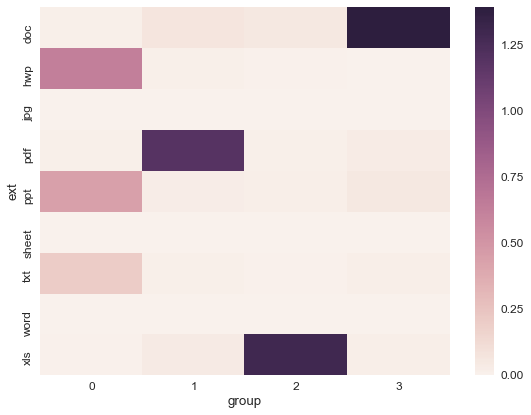

In [107]:
plt.subplots(figsize=(8,6))

sns.heatmap(df_ext_mean.T, annot=False)

plt.tight_layout()

In [108]:
df_ext.head()

ext,doc,hwp,jpg,pdf,ppt,sheet,txt,word,xls,group
sessionid,,,,,,,,,,
s0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1
s1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1
s10,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
s100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
s1000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [109]:
# be careful with the values; the group no. changes randomly
group_name = {0: 'gr_hwp',
              1: 'gr_pdf',
              2: 'gr_xls',
              3: 'gr_doc'}

In [110]:
df_ext['group'] = df_ext['group'].replace(group_name)

In [111]:
df_ext.head()

ext,doc,hwp,jpg,pdf,ppt,sheet,txt,word,xls,group
sessionid,,,,,,,,,,
s0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,gr_pdf
s1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,gr_pdf
s10,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gr_hwp
s100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,gr_xls
s1000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,gr_pdf


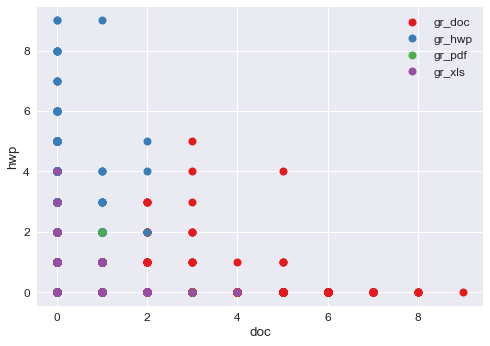

In [112]:
groups = df_ext.groupby("group")

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.doc, group.hwp, marker='o', linestyle='', ms=8, label=name)
    ax.legend()

plt.xlabel("doc")
plt.ylabel("hwp")
    
plt.show()

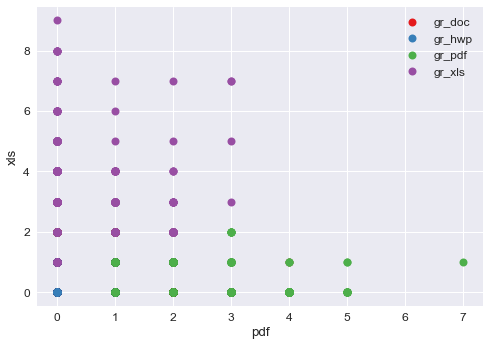

In [113]:
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.pdf, group.xls, marker='o', linestyle='', ms=8, label=name)
    ax.legend()

plt.xlabel("pdf")
plt.ylabel("xls")
    
plt.show()

In [114]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,open,noview,pdf,s0,localstorage,2016-07-18,per_dir
1,close,noview,pdf,s0,localstorage,2016-07-18,per_dir
2,open,view,pdf,s0,mypolarisdrive,2016-07-18,pub_dir
3,close,view,pdf,s0,mypolarisdrive,2016-07-18,pub_dir
4,open,noview,pdf,s1,otherapp,2016-07-06,main


In [115]:
df_ext['group'][:10]

sessionid
s0         gr_pdf
s1         gr_pdf
s10        gr_hwp
s100       gr_xls
s1000      gr_pdf
s10000     gr_pdf
s100000    gr_pdf
s100001    gr_doc
s100002    gr_pdf
s100003    gr_pdf
Name: group, dtype: object

In [116]:
df_cluster = df.query("actiontype != 'close'").set_index("sessionid")

df_cluster['group'] = df_ext['group']
df_cluster['group'] = df_cluster['group']

df_cluster.reset_index(inplace=True)
df_cluster.head()

,sessionid,actiontype,ismydoc,ext,documentposition,datetime,screen,group
0,s0,open,noview,pdf,localstorage,2016-07-18,per_dir,gr_pdf
1,s0,open,view,pdf,mypolarisdrive,2016-07-18,pub_dir,gr_pdf
2,s1,open,noview,pdf,otherapp,2016-07-06,main,gr_pdf
3,s1,reset,view,pdf,otherapp,2016-07-06,main,gr_pdf
4,s2,open,noview,pdf,otherapp,2016-07-20,main,gr_pdf


In [117]:
df_cluster.group.value_counts()

gr_pdf    49679
gr_doc    48118
gr_xls    46057
gr_hwp    30085
Name: group, dtype: int64

In [118]:
def conv_rt_by_grp(gr):
    df_gr_screen = df_cluster[df_cluster['group'] == gr]\
                     .groupby(["datetime", "screen"])['sessionid']\
                     .nunique().unstack().fillna(0).astype(int)
            
    conver_cnt = df_gr_screen.mean().apply(lambda x: int(x)).sort_values(ascending=False)
    conver_rt = [conver_cnt[i + 1] / (conver_cnt[i] * 1.0) * 100 for i in range(len(conver_cnt)) if i < 6]
    conver_rt = pd.Series(conver_rt, index=fun_label).fillna(0)
    
    return conver_rt

In [119]:
conv_rt_pdf = conv_rt_by_grp('gr_pdf')
conv_rt_pdf

main -> pub_dir                   16.947566
pub_dir -> per_dir                30.939227
per_dir -> inproduct_web           8.928571
inproduct_web -> inproduct_mob    60.000000
inproduct_mob -> purchase_page     0.000000
purchase_page -> purchase_done     0.000000
dtype: float64

In [120]:
conv_rt_doc = conv_rt_by_grp('gr_doc')
conv_rt_doc

main -> pub_dir                   31.754161
pub_dir -> per_dir                33.870968
per_dir -> inproduct_web          95.238095
inproduct_web -> inproduct_mob     7.500000
inproduct_mob -> purchase_page     0.000000
purchase_page -> purchase_done     0.000000
dtype: float64

In [121]:
conv_rt_xls = conv_rt_by_grp('gr_xls')
conv_rt_xls

main -> pub_dir                   38.278146
pub_dir -> per_dir                30.103806
per_dir -> inproduct_web          29.885057
inproduct_web -> inproduct_mob    50.000000
inproduct_mob -> purchase_page     0.000000
purchase_page -> purchase_done     0.000000
dtype: float64

In [122]:
conv_rt_hwp = conv_rt_by_grp('gr_hwp')
conv_rt_hwp

main -> pub_dir                   36.873747
pub_dir -> per_dir                55.434783
per_dir -> inproduct_web          39.215686
inproduct_web -> inproduct_mob     7.500000
inproduct_mob -> purchase_page     0.000000
purchase_page -> purchase_done     0.000000
dtype: float64

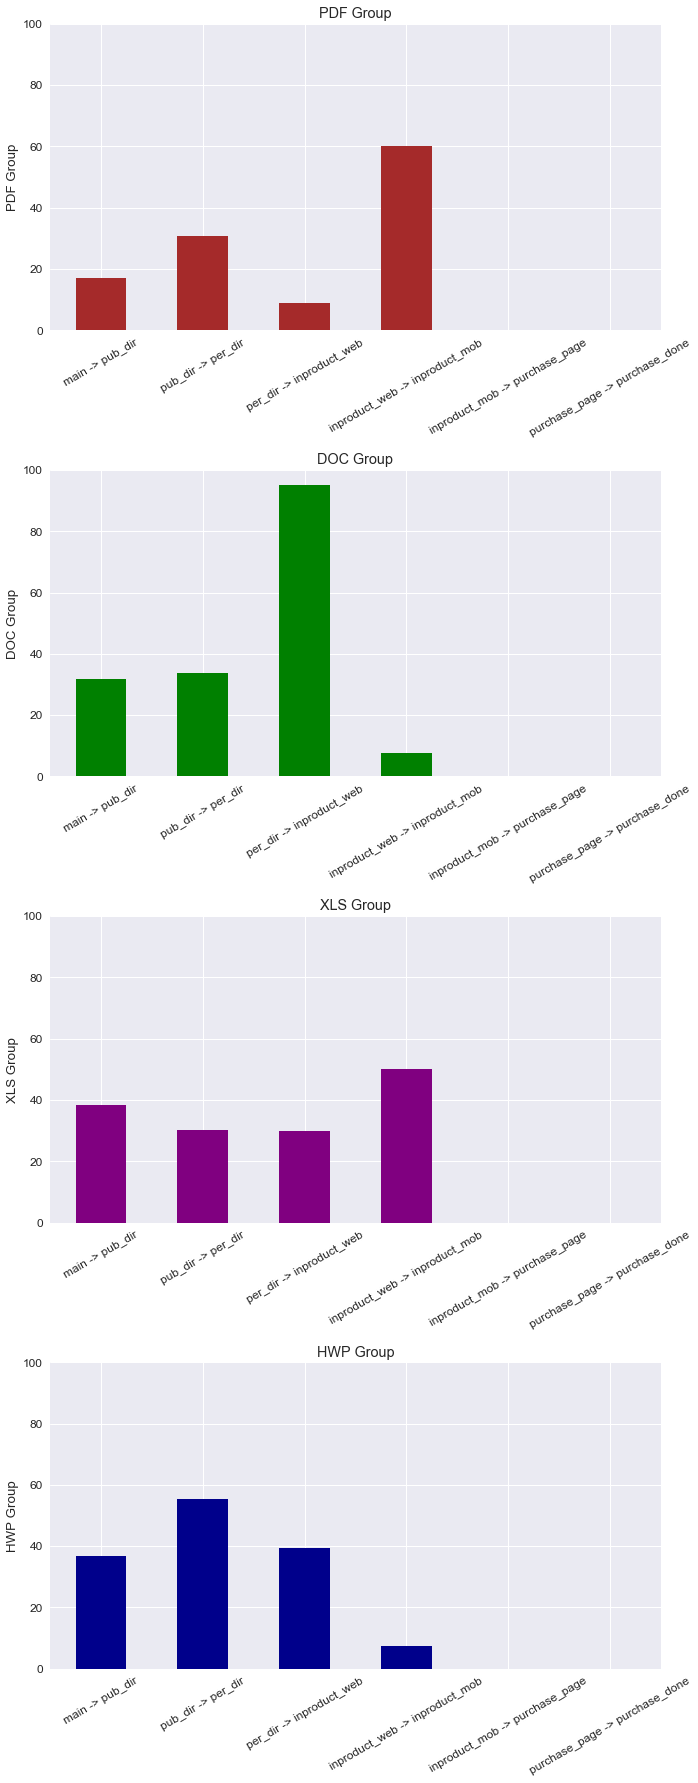

In [123]:
fig, ax = plt.subplots(4, 1, figsize=(10,25), sharey=True)

conv_rt_pdf.plot(kind='bar', ax=ax[0], color = 'brown', rot=30)
ax[0].set_title('PDF Group')
ax[0].set_ylabel('PDF Group')

conv_rt_doc.plot(kind='bar', ax=ax[1], color = 'green', rot=30)
ax[1].set_ylabel('DOC Group')
ax[1].set_title('DOC Group')

conv_rt_xls.plot(kind='bar', ax=ax[2], color = 'purple', rot=30)
ax[2].set_ylabel('XLS Group')
ax[2].set_title('XLS Group')

conv_rt_hwp.plot(kind='bar', ax=ax[3], color = 'darkblue', rot=30)
ax[3].set_ylabel('HWP Group')
ax[3].set_title('HWP Group')

plt.tight_layout()

In [124]:
gr_pdf_avg = conv_rt_pdf.replace(0, np.nan).mean()
gr_doc_avg = conv_rt_doc.replace(0, np.nan).mean()
gr_xls_avg = conv_rt_xls.replace(0, np.nan).mean()
gr_hwp_avg = conv_rt_hwp.replace(0, np.nan).mean()

print gr_pdf_avg
print gr_doc_avg
print gr_xls_avg
print gr_hwp_avg

29.2038408727
42.0908060779
37.0667523488
34.7560540945


In [125]:
weights = [1, 1.3, 1.5, 2, 2.1, 2.2]

weights

[1, 1.3, 1.5, 2, 2.1, 2.2]

In [126]:
conv_rt_pdf

main -> pub_dir                   16.947566
pub_dir -> per_dir                30.939227
per_dir -> inproduct_web           8.928571
inproduct_web -> inproduct_mob    60.000000
inproduct_mob -> purchase_page     0.000000
purchase_page -> purchase_done     0.000000
dtype: float64

In [127]:
def weight_avg(gr):
    w = (gr.values * weights).sum() / len(gr)
    
    return w

In [128]:
gr_pdf_w = weight_avg(conv_rt_pdf)
gr_doc_w = weight_avg(conv_rt_doc)
gr_xls_w = weight_avg(conv_rt_xls)
gr_hwp_w = weight_avg(conv_rt_hwp)

print gr_pdf_w
print gr_doc_w
print gr_xls_w
print gr_hwp_w

31.760236193511066
38.94059370888085
37.0401133331911
30.460415716343174


In [129]:
zip([gr_pdf_avg, gr_doc_avg, gr_xls_avg, gr_hwp_avg], [gr_pdf_w, gr_doc_w, gr_xls_w, gr_hwp_w])

[(29.2038408727449, 31.760236193511066),
 (42.09080607791421, 38.94059370888085),
 (37.06675234875058, 37.0401133331911),
 (34.75605409454886, 30.460415716343174)]

In [130]:
avg_df = pd.DataFrame(list(zip([gr_pdf_avg, gr_doc_avg, gr_xls_avg, gr_hwp_avg],\
                                   [gr_pdf_w, gr_doc_w, gr_xls_w, gr_hwp_w])), \
                                   columns = ['mean', 'wg_mean'],\
                                   index = ['gr_pdf', 'gr_doc', 'gr_xls', 'gr_hwp'])

avg_df

,mean,wg_mean
gr_pdf,29.203841,31.760236
gr_doc,42.090806,38.940594
gr_xls,37.066752,37.040113
gr_hwp,34.756054,30.460416


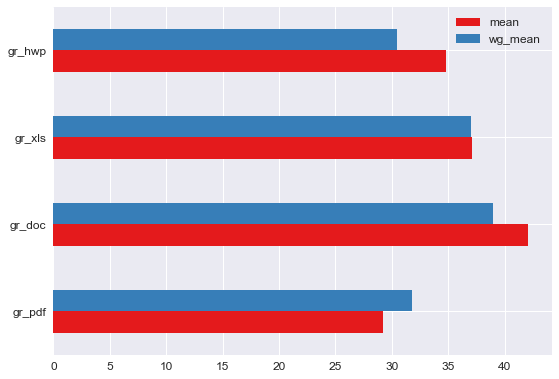

In [131]:
avg_df.plot(kind='barh')

plt.tight_layout()